<a href="https://colab.research.google.com/github/KarinaKarina6/ML_HWs/blob/task_2/ML_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install shap > None

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

Этот набор данных содержит информацию о различных признаках набора фруктов. Набор данных включает в себя такие данные, как идентификатор плода, размер, вес, сладость, хрусткость, сочность, спелость, кислотность и качество. Задача состоит в том, чтобы классифицировать качество фрукта.

In [3]:
data = pd.read_csv('apple_quality.csv')

In [4]:
# удалить строку с пропусками
df = data.copy().dropna()
df.isna().sum()

# удалить стоблец "A_id"
df.drop('A_id', inplace=True, axis=1)

# задать 'good' как 1, а 'bad' как 0. Это понадобиться для дальнейшего
# использования данных на моделях машинного обучения
df['Quality'] = df['Quality'].map({'good':1, 'bad':0})

In [5]:
df_class = df['Quality']
df_features = df[df.columns[:-1]]

In [6]:
# разделение набора данных на train и test
X_train, X_test, y_train, y_test = train_test_split(df_features, df_class, random_state=42, test_size=0.20)

In [25]:
# подбор гиперпараметров
parameters = {
    'n_estimators': np.arange(10, 100, 20),
    'max_depth': list(range(1, 10)) + [None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'random_state': [42]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=5,
)

In [26]:
%%time

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
criterion: gini
max_depth: None
n_estimators: 70
random_state: 42
CPU times: user 4.43 s, sys: 442 ms, total: 4.87 s
Wall time: 2min 47s


In [28]:
# запишем лучшую модель и выведем по ней f1 score
rf = RandomForestClassifier(**best_parameters)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
print(f'f1 score: {f1_score(y_test, y_preds)}')

f1 score: 0.8927680798004988


**Интерпретация**

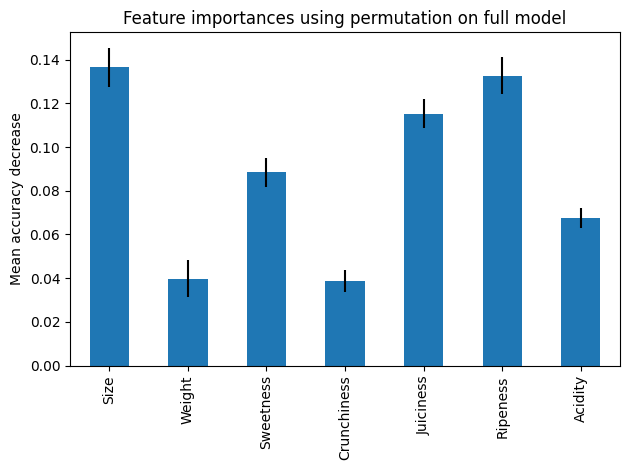

In [32]:
importances = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Действительно, признаки размер, спелость, сочность и сладость являются важными для определеления качества фрукта.

In [37]:
explainer = shap.TreeExplainer(rf)

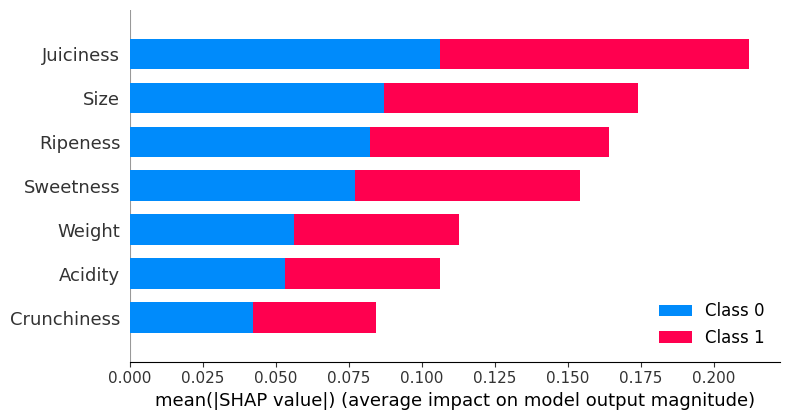

In [38]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

Высокие значения показателя mean(|SHAP value|) для признаков размер, вес, сладость, хрусткость, сочность, спелость и кислотность указывают на то, что фрукт относится к классу 1, то есть имеет хорошее качество.